In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from math import pi

from bokeh.io import show, output_file
from bokeh.layouts import row
from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource

# Read csvs

In [3]:
ings = pd.read_csv('data/ings.csv', encoding = "ISO-8859-1", index_col=0)
#prods = prods.drop_duplicates(subset = 'product')
prods = pd.read_csv('data/prods.csv', encoding = "ISO-8859-1", index_col=0)
#prods = prods.drop_duplicates(subset = 'product')
prod_ing = pd.read_csv('data/prod_ing.csv', encoding = "ISO-8859-1", index_col=0)
prod_ing = prod_ing.drop(['diff'], axis = 1)
#prod_ing = prod_ing.sort_values(['id', 'order'])

print('Number of products: ', len(prods))
print('Number of unique ingredients: ', len(ings))
print('Number of total ingredients: ', len(prod_ing))

ValueError: labels ['diff'] not contained in axis

In [7]:
ings = pd.read_csv('data/og/ingredients.csv', encoding = "ISO-8859-1", index_col=0)
#drop duplicates that have same id and ingredient (they wouldn't be listed twice)
ings = ings.drop_duplicates(subset = ['ingredient', 'id'])

prods = pd.read_csv('data/og/products.csv', encoding = "ISO-8859-1", index_col=0)
#drop the same products
prods = prods.drop_duplicates(subset = 'product')

print('Number of products: ', len(prods))
print('Number of ingredients: ', len(ings))
print('Scraping took 3 days 23:31:45 at 17.27 seconds per product')

Number of products:  19352
Number of ingredients:  545617
Scraping took 3 days 23:31:45 at 17.27 seconds per product


# Products

## Reorder columns

In [8]:
# I want the columns in a more natural order
prods = prods[['id', 'product', 'brand', 'price', 'rating', 'ratingsCount', 'categories', 'notes']]

# Remove all spaces for easier cleaning
prods['categories'] = prods['categories'].str.replace(' ', '')
prods['notes'] = prods['notes'].str.replace(' ', '')
prods['price'] = prods['price'].replace({'\$':'', ' ': ''}, regex = True)
prods['price'] = prods['price'].replace({'Nan':'NaN'}, regex = True)
prods['price'] = prods['price'].str.strip()
prods['price'] = prods['price'].astype(str).astype(float)


##Culling of products that aren't Face or Body Skincare
#prods[~prods['categories'].str.contains("Skincare", case=True, flags=0, regex=True)]
prods = prods[prods['categories'].str.contains("FaceSkincare*", na=False)]

prods.head(5)

,id,product,brand,price,rating,ratingsCount,categories,notes
0,0,Naturally Gentle Eye Makeup Remover,Clinique,20.00,5.0,16,"FaceSkincare,EyeCare,EyeMakeupRemover","ContainsParaben,SulfateFree,AlcoholFree"
2,2,Foot Cream Norwegian Formula,Neutrogena,23.82,4.9,84,"FaceSkincare,Moisturizers","PromotesWoundHealing,Brightening,ContainsParab..."
3,3,Essential Power Skin Refiner_Moisture,Laneige,28.20,5.0,12,"FaceSkincare,Toners","PromotesWoundHealing,Brightening,ParabenFree,S..."
4,4,Daily Facials Gentle Clean 4-in-1 Water Activa...,Olay,32.25,4.9,17,"FaceSkincare,Cleansers,CleansingWipes","Anti-Aging,PromotesWoundHealing,ContainsParabe..."
5,5,Gokujyun Lotion Refill Pouch,Hada Labo,13.26,4.9,55,"FaceSkincare,Toners","PromotesWoundHealing,ContainsParaben,SulfateFr..."


In [9]:
products_keep = prods['id'].tolist()

In [10]:
print('There are', len(prods), 'products')

There are 15980 products


### Convert 'categories' and 'notes' into dummy data

In [11]:
#create categories dataframe that we can use to analyze and join to product dataframe
categories = prods['categories'].str.get_dummies(sep=',')
categories = categories.add_prefix('cat_')
#Drop skincare column as we don't need it since all will be one
categories = categories.drop(['cat_FaceSkincare'], axis =1)
#Drop columns if it has less than 100 products
categories.drop([col for col, val in categories.sum().iteritems() if val < 100], axis=1, inplace=True)

#create notes dataframe that we can use to analyze and join to product dataframe
notes_all = prods['notes'].str.get_dummies(sep=',')
notes_all = notes_all.add_prefix('note_')
notes_keep = notes_all.columns.isin(['note_SulfateFree',
                  'note_ParabenFree',
                  'note_AlcoholFree',
                  'note_Anti-Aging',
                  'note_PromotesWoundHealing',
                  'note_Brightening',
                  'note_Acne-Fighting',
                  'note_UVProtection',
                  'note_ContainsAlcohol',
                  'note_ContainsParaben',
                  'note_ContainsSulfate'])

notes = notes_all.loc[:,notes_keep]

#join to create product dataframe
prods = pd.concat([prods, categories, notes] , axis=1)
# Drop repeated columns 
prods = prods.drop(['categories', 'notes'], axis =1)

# 225 down to 44 columns
prods.head()

,id,product,brand,price,rating,ratingsCount,cat_Acne&BlemishTreatments,cat_Ampoules,cat_BodySkincare,cat_Cleansers,...,note_AlcoholFree,note_Anti-Aging,note_Brightening,note_ContainsAlcohol,note_ContainsParaben,note_ContainsSulfate,note_ParabenFree,note_PromotesWoundHealing,note_SulfateFree,note_UVProtection
0,0,Naturally Gentle Eye Makeup Remover,Clinique,20.00,5.0,16,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
2,2,Foot Cream Norwegian Formula,Neutrogena,23.82,4.9,84,0,0,0,0,...,1,0,1,0,1,0,0,1,1,0
3,3,Essential Power Skin Refiner_Moisture,Laneige,28.20,5.0,12,0,0,0,0,...,0,0,1,1,0,0,1,1,1,0
4,4,Daily Facials Gentle Clean 4-in-1 Water Activa...,Olay,32.25,4.9,17,0,0,0,1,...,1,1,0,0,1,0,0,1,1,0
5,5,Gokujyun Lotion Refill Pouch,Hada Labo,13.26,4.9,55,0,0,0,0,...,1,0,0,0,1,0,0,1,1,0


Get list of remaining product id's to cull ingredients

### Use id's of both ingredients and products to ensure we have the same products

Create list of unique product id's to cull ingredient id's

In [12]:
id_list = prods['id'].tolist()
print('There are', len(id_list), 'unique products ids')

There are 15980 unique products ids


In [13]:
ing_ids = ings[ings['id'].isin(id_list)]
ing_ids_list = ing_ids['id'].unique()
print('There are', len(ing_ids), 'unique ingredient ids')

There are 446618 unique ingredient ids


In [14]:
prods = prods[prods['id'].isin(ing_ids_list)]
prods_ids_list = prods['id'].unique()
print('There are', len(prods_ids_list), 'unique products')

There are 15945 unique products


In [15]:
#check unique id differences.
diff = set(prods_ids_list) - set(ing_ids_list)
diff

set()

In [16]:
# Create csv of wide data set
prods.to_csv('data/prods.csv')

### Categories summary

In [17]:
# Convert from wide to long and rename default columns
categories_long = categories.stack().reset_index().rename(columns = {'level_0': 'id', 'level_1': 'category', 0: 'count'})
# Drop all rows where the count == 0 (don't need to count these)
categories_long = categories_long[categories_long['count'] != 0]
# Drp the 'cat_' prefix we used to create dummy data
categories_long['category'] = categories_long['category'].replace({'cat_': ''}, regex = True)
categories_count = pd.DataFrame(categories_long['category'].value_counts())
categories_count['%'] = categories_count['category']/categories_count['category'].sum()*100
categories_count.head()

,category,%
Moisturizers,4024,12.972276
Cleansers,3191,10.286912
Treatments,3080,9.929078
Essence,2231,7.192134
Serums,2231,7.192134


In [18]:
print('There are', len(categories_count), 'categories')

There are 27 categories


### Notes summary

In [19]:
# Convert from wide to long and rename default columns
notes_long = notes.stack().reset_index().rename(columns = {'level_0': 'id', 'level_1': 'note', 0: 'count'})
# Drop all rows where the count == 0 (don't need to count these)
notes_long = notes_long[notes_long['count'] != 0]
# Drp the 'note_' prefix we used to create dummy data
notes_long['note'] = notes_long['note'].replace({'note_': ''}, regex = True)
notes_count = pd.DataFrame(notes_long['note'].value_counts())
notes_count['%'] = notes_count['note']/notes_count['note'].sum()*100
notes_count

,note,%
SulfateFree,15254,19.725340
ParabenFree,13335,17.243832
AlcoholFree,12981,16.786065
Anti-Aging,10310,13.332126
PromotesWoundHealing,6121,7.915223
Brightening,5937,7.677288
Acne-Fighting,3548,4.588010
UVProtection,3476,4.494905
ContainsAlcohol,2999,3.878084
ContainsParaben,2645,3.420318


In [20]:
#notes_count.to_csv('data/notes_count.csv')
print('There are', len(notes_count), 'notes.')

There are 11 notes.


### Ratings summary

In [21]:
# Most products don't have a rating... might drop this further down the line
prods['rating'].value_counts().head()

0.0    12490
5.0      605
4.0      463
4.3      296
4.4      255
Name: rating, dtype: int64

### Visualization of category and notes count

In [17]:
from bokeh.models.widgets import Panel, Tabs

output_file('categories.html')
source = ColumnDataSource(categories_count)

p = figure(x_range=categories_count.index.values, 
           plot_height=500, 
           plot_width = 800, 
           title="Category count",
           tools = '',
           logo = None)
p.vbar(x=categories_count.index.values, top=categories_count.iloc[:,0], width=0.9)
p.xaxis.major_label_orientation = -pi/4
p.yaxis.major_label_orientation = "vertical"

p.xgrid.grid_line_color = None
p.y_range.start = 0


p2 = figure(x_range=notes_count.index.values, 
           plot_height=500, 
           plot_width = 800, 
           title="Notes count",
           tools = '',
           logo = None)
p2.vbar(x=notes_count.index.values, top=notes_count.iloc[:,0], width=0.9)
p2.xaxis.major_label_orientation = -pi/4
p2.yaxis.major_label_orientation = "vertical"

p2.xgrid.grid_line_color = None
p2.y_range.start = 0

tab1 = Panel(child=p, title="Categories")
tab2 = Panel(child=p2, title="Notes")
tabs = Tabs(tabs=[ tab1, tab2 ])

show(tabs)

### Histogram of prices

c:\users\isabelbeard\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


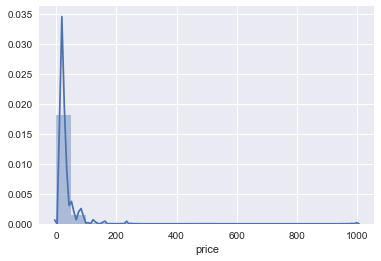

In [18]:
price = prods['price'].fillna(axis=0, method='ffill')
sns.distplot(price, bins = 20);

# Ingredients

Get the columns in a more natural order and strip()

In [22]:
# I want the columns in a more natural order
ings = ings[['id', 'ingredient', 'ewg', 'cir', 'function', 'notes']]
ings['ingredient'] = ings['ingredient'].str.replace('\r\r\n()', '').str.strip('()')
ings['notes'] = ings['notes'].str.replace('\r\r\n\r\r\n', ', ').str.strip()
ings.head()

,id,ingredient,ewg,cir,function,notes
0,0,Water,1,NaN,Solvent,NaN
1,0,Hydrogenated Polyisobutene,1,A,"Skin Conditioning, Emollient, Viscosity Contro...",Comedogenic Rating (1)
2,0,Butylene Glycol,1,A,"Solvent, Skin Conditioning, Masking, Fragrance...","Good for Dry Skin, Comedogenic Rating (1)"
3,0,Sesamum Indicum (Sesame) Seed Oil,1,A,"Skin Conditioning, Masking, Emollient, Fragran...","Bad for Oily Skin, Comedogenic Rating (3)"
4,0,Ammonium Acryloyldimethyltaurate/VP Copolymer,1,NaN,Viscosity Controlling,NaN


Grab the 'id' and 'ingredient' to make a new prod_ing dataframe to retain order

In [23]:
prod_ing = ings[['id', 'ingredient']]

#### Summary

In [24]:
print('There are', len(ings), 'ingredients in the database with', ings['ingredient'].nunique(), 'unique ingredients')

There are 545617 ingredients in the database with 7324 unique ingredients


### Drop duplicates
Want the ingredients dataframe to just have unique ingredients

In [25]:
ings = ings.drop_duplicates(subset = 'ingredient')
print(len(ings))

7325


### Function

Look at just function

In [26]:
ings['function'] = ings['function'].str.replace('- ', '').str.strip('.').str.strip().str.replace(', ', ',')
function = ings['function'].str.get_dummies(sep=',')
function = function.add_prefix('func_')

#down from 216 to 28 when removing less than 100
function.drop([col for col, val in function.sum().iteritems() if val < 100], axis=1, inplace=True)
function.head()

,func_Abrasive,func_Antimicrobial,func_Antioxidant,func_Antistatic Agent,func_Astringent,func_Binding,func_Binding Agent,func_Buffering Agent,func_Bulking Agent,func_Cleansing,...,func_Opacifying,func_Perfuming,func_Skin Conditioning,func_Skin Protecting,func_Solvent,func_Sufactant,func_Surfactant,func_Tonic,func_Viscosity Controlling,func_Viscosity Increasing Agent
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Drop functions with a count less than 200

### Function clean 

In [27]:
#join to create product dataframe
ings = pd.concat([ings, function] , axis=1)
# Drop repeated columns 
ings = ings.drop(['function'], axis =1)
ings.head(3)

,id,ingredient,ewg,cir,notes,func_Abrasive,func_Antimicrobial,func_Antioxidant,func_Antistatic Agent,func_Astringent,...,func_Opacifying,func_Perfuming,func_Skin Conditioning,func_Skin Protecting,func_Solvent,func_Sufactant,func_Surfactant,func_Tonic,func_Viscosity Controlling,func_Viscosity Increasing Agent
0,0,Water,1,NaN,NaN,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,Hydrogenated Polyisobutene,1,A,Comedogenic Rating (1),0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
2,0,Butylene Glycol,1,A,"Good for Dry Skin, Comedogenic Rating (1)",0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0


### Notes

In [28]:
ings['notes'] = ings['notes'].str.replace(', ', ',').str.strip()
notes = ings['notes'].str.get_dummies(sep=',')
notes = notes.add_prefix('notes_')

notes.head()

,notes_Acne-Fighting,notes_Alcohol,notes_Anti-Aging,notes_Bad for Dry Skin,notes_Bad for Oily Skin,notes_Bad for Sensitive Skin,notes_Brightening,notes_Comedogenic Rating (1),notes_Comedogenic Rating (2),notes_Comedogenic Rating (3),notes_Comedogenic Rating (4),notes_Comedogenic Rating (5),notes_Good for Dry Skin,notes_Good for Oily Skin,notes_Good for Sensitive Skin,notes_Paraben,notes_Promotes Wound Healing,notes_Sulfate,notes_UV Protection
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
#join to create product dataframe
ings = pd.concat([ings, notes] , axis=1)
# Drop repeated columns 
ings = ings.drop(['notes'], axis =1)
ings.head(3)

,id,ingredient,ewg,cir,func_Abrasive,func_Antimicrobial,func_Antioxidant,func_Antistatic Agent,func_Astringent,func_Binding,...,notes_Comedogenic Rating (3),notes_Comedogenic Rating (4),notes_Comedogenic Rating (5),notes_Good for Dry Skin,notes_Good for Oily Skin,notes_Good for Sensitive Skin,notes_Paraben,notes_Promotes Wound Healing,notes_Sulfate,notes_UV Protection
0,0,Water,1,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,Hydrogenated Polyisobutene,1,A,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,Butylene Glycol,1,A,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [30]:
ings.to_csv('data/ings.csv')

### Visualize notes

In [31]:
# Convert from wide to long and rename default columns
notes_long = notes.stack().reset_index().rename(columns = {'level_0': 'id', 'level_1': 'notes', 0: 'count'})

# Drop all rows where the count == 0 (don't need to count these)
notes_long = notes_long[notes_long['count'] != 0]
notes_long['notes'] = notes_long['notes'].replace({'notes_': ''}, regex = True)
notes_count = pd.DataFrame(notes_long['notes'].value_counts())
notes_count['%'] = notes_count['notes']/notes_count['notes'].sum()*100
notes_count


,notes,%
Bad for Oily Skin,75,13.736264
Bad for Sensitive Skin,61,11.172161
Good for Dry Skin,50,9.157509
Brightening,43,7.875458
Anti-Aging,38,6.959707
Comedogenic Rating (2),35,6.410256
UV Protection,34,6.227106
Good for Sensitive Skin,29,5.311355
Comedogenic Rating (3),28,5.128205
Acne-Fighting,23,4.212454


### Visualize functions


In [32]:
# Convert from wide to long and rename default columns
function_long = function.stack().reset_index().rename(columns = {'level_0': 'id', 'level_1': 'function', 0: 'count'})

# Drop all rows where the count == 0 (don't need to count these)
function_long = function_long[function_long['count'] != 0]

# Drp the 'func_' prefix we used to create dummy data
function_long['function'] = function_long['function'].replace({'func_': ''}, regex = True)
function_count = pd.DataFrame(function_long['function'].value_counts())
function_count['%'] = function_count['function']/function_count['function'].sum()*100
function_count

,function,%
Skin Conditioning,3330,27.798648
Emollient,889,7.421321
Surfactant,792,6.611570
Hair Conditioning,762,6.361132
Emulsifying,756,6.311044
Masking,489,4.082144
Viscosity Controlling,480,4.007012
Fragrance,414,3.456048
Humectant,374,3.122130
Film Forming,330,2.754821


# Product + Ingredients

Need to add a column to retain the order

In [33]:
prod_ing = prod_ing.reset_index(drop=True)


In [34]:
prod_ing['diff'] = prod_ing['id'] - prod_ing['id'].shift(-1)
prod_ing.tail(3)

,id,ingredient,diff
545614,19926,Sodium Citrate,0.0
545615,19926,Disodium EDTA,0.0
545616,19926,Phenoxyethanol,NaN


In [ ]:
prod_ing['order'] = 0
prod_id = 0
count = 1
for i in range(len(prod_ing)):
    diff = prod_ing.loc[i, ['diff']]
    prod_ing.loc[i, ['order']] = count
    
    if diff.any() == -1:
        count = 1
    else:
        count += 1

In [ ]:
#prod_ing.to_csv('data/prod_ing.csv')